In [1]:
import numpy as np
import pandas as pd
from pymatgen.io.cif import CifParser
import sys, os
sys.path.append('../')
from tqdm import tqdm
import json
from distortion_learning.super_cell import SuperCell
from distortion_learning.constants import SG_LABELS
from multiprocessing import Pool, cpu_count
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

# Filter pure metals and alloys (CIFs)

In [ ]:
source_directory = '../data/structure/ICSD_cifs'
pure_metal_directory = '../data/structure/pure_metal_cif'
alloy_directory = '../data/structure/alloy_cif'
SuperCell.process_cif_files(source_directory, pure_metal_directory, alloy_directory)

### Print the most frequent space groups in the folder

In [ ]:
pure_metal_directory = '../data/structure/pure_metal_cif'
# Initialize a dictionary to count files for each space group and a total file counter
space_group_counts = {}
total_files = 0

# Traverse all .cif files in the directory
for filename in os.listdir(pure_metal_directory):
    if filename.endswith('.cif'):
        total_files += 1
        file_path = os.path.join(pure_metal_directory, filename)
        
        parser = CifParser(file_path)
        structure_df = parser.as_dict()
        structure_df = structure_df[list(structure_df.keys())[0]]
        space_group = structure_df["_symmetry_Int_Tables_number"]
        
        if space_group in space_group_counts:
            space_group_counts[space_group] += 1
        else:
            space_group_counts[space_group] = 1

# Convert the space_group_counts dictionary to a pandas DataFrame
df = pd.DataFrame(list(space_group_counts.items()), columns=['Space Group', 'Count'])

# Sort the DataFrame by 'Count' in descending order
df.sort_values(by='Count', ascending=False, inplace=True)

# Print the total number of .cif files processed
print(f"Total number of .cif files: {total_files}")

# Print the space groups, their counts, and their labels
for index, row in df.iterrows():
    space_group = row['Space Group']
    count = row['Count']
    label = SG_LABELS.get(str(space_group), "Unknown")  # Get the label, default to 'Unknown' if not found
    print(f"Space Group: {space_group}, Label: {label}, Count: {count}")

Subtotal number of files: 1172/1438 = 81.5%
* Space Group: 225, Label: Fm-3m, Count: 391
* Space Group: 194, Label: P6_3/mmc, Count: 341
* Space Group: 229, Label: Im-3m, Count: 273
* Space Group: 139, Label: I4/mmm, Count: 83
* Space Group: 141, Label: I4_1/amd, Count: 52
* Space Group: 140, Label: I4/mcm, Count: 32

### Save the cif directories of the target space group

In [10]:
output_directory = '../data/structure'
output_filename = 'pure_metal_list.json'

# The space groups we want to keep
target_space_groups = ['225', '194', '229', '139', '141', '140']
# Initialize a dictionary to store file paths for each space group
files_by_space_group = {sg: [] for sg in target_space_groups}

# Traverse all .cif files in the directory
for filename in os.listdir(pure_metal_directory):
    if filename.endswith('.cif'):
        file_path = os.path.join(pure_metal_directory, filename)
        
        parser = CifParser(file_path)
        structure_df = parser.as_dict()
        structure_df = structure_df[list(structure_df.keys())[0]]
        space_group = structure_df["_symmetry_Int_Tables_number"]

        if space_group in target_space_groups:
            files_by_space_group[space_group].append(file_path)

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Save the dictionary to a JSON file
with open(os.path.join(output_directory, output_filename), 'w') as f:
    json.dump(files_by_space_group, f, indent=4)

print(f"File saved to {os.path.join(output_directory, output_filename)}")

File saved to ../data/structure/pure_metal_list.json


# Generate Supercell

In [18]:
dim = 5
folder = '../data/structure/pure_metal_cif'
filename = 'icsd_001425.cif'
sc = SuperCell()
sc.load_cif(folder + '/' + filename)
print(f"Atoms Information:\n{sc.atoms_info}\n")
print(f"Space Group: {sc.space_group}\n")
print(f"Supercell Lattice:\n{sc.supercell_lattice}\n")
supercell_info = sc.generate_supercell(dim)
print(f"Supercell Information:\n{supercell_info}")

Atoms Information:
  element         x             y         z     uiso  occupancy
0    Be0+  0.659854  1.142900e+00  2.688225  0.00734        1.0
1    Be0+  1.319707 -7.401487e-17  0.896075  0.00734        1.0

Space Group: 194

Supercell Lattice:
Lattice(a=2.2858, b=2.2858, c=3.5843, alpha=90, beta=90, gamma=120)

Supercell Information:
    element         x       y          z     uiso  occupancy
0      Be0+  0.659854  1.1429   2.688225  0.00734        1.0
1      Be0+  0.659854  1.1429   6.272525  0.00734        1.0
2      Be0+  0.659854  1.1429   9.856825  0.00734        1.0
3      Be0+  0.659854  1.1429  13.441125  0.00734        1.0
4      Be0+  0.659854  1.1429  17.025425  0.00734        1.0
..      ...       ...     ...        ...      ...        ...
245    Be0+  9.237951  4.5716   0.896075  0.00734        1.0
246    Be0+  9.237951  4.5716   4.480375  0.00734        1.0
247    Be0+  9.237951  4.5716   8.064675  0.00734        1.0
248    Be0+  9.237951  4.5716  11.648975  0.00734

In [19]:
dim = 5
source_directory = '../data/structure/pure_metal_cif'
target_directory = '../data/structure/pure_metal_supercell_json'
SuperCell.generate_supercell_multi(dim, source_directory, target_directory, file_list='../data/structure/pure_metal_list.json')

100%|██████████| 1172/1172 [02:11<00:00,  8.93it/s]


# Add Point Defect

## Type 1: vacancy
A vacancy defect occurs when an atom site in the crystal lattice is unoccupied. In essence, there's a "hole" where an atom should be. Vacancies can occur naturally due to thermal vibrations in the lattice or can be induced through various processes. They are essential for diffusion, as atoms move from one site to another through vacancies, and can significantly influence the mechanical, electrical, and thermal properties of the material.

For each metal structure, uniformly randomly choose 3 vacancy percentage (number of vacancy atoms / total atoms) from 10^(-4) to 10^(-1) and calculate the resulting structure.

For metals, this percentage is usually ~10^(-4).


In [3]:
source_directory = '../data/structure/pure_metal_supercell_json'
target_directory = '../data/structure/pure_metal_vac_json'
ratio_range = [10**(-2), 10**(-1)]
SuperCell.apply_point_defect_multi(source_directory, target_directory, 'vacancy', ratio_range)

100%|██████████| 1173/1173 [00:05<00:00, 212.00it/s]


## Type 2: self-interstitial
A self-interstitial defect arises when an atom from the crystal is squeezed into an interstitial site, a small space between the regular atomic sites of the lattice. This defect creates a high degree of local distortion due to the additional atom forcing its way into a position that is not normally an atom site. Self-interstitials can affect the density, electrical properties, and diffusion behavior of materials.

For each metal structure, uniformly randomly choose 3 self-interstitial percentage (number of self-interstitial atoms / total atoms) from 10^(-5) to 5*10^(-2). 

For each self-interstitial atom, we uniformly randomly add it to the original structure.

self-interstitial percentage is usually smaller than vacancy percentage.

In [5]:
source_directory = '../data/structure/pure_metal_supercell_json'
target_directory = '../data/structure/pure_metal_selfint_json'
ratio_range = [10**(-2), 10**(-1)]
SuperCell.apply_point_defect_multi(source_directory, target_directory, 'self_interstitial', ratio_range)

100%|██████████| 1173/1173 [00:08<00:00, 141.33it/s]


## Type 3.1: substitutional impurities
Substitutional impurities occur when an atom in the crystal lattice is replaced by a different type of atom, typically of similar size to fit properly in the lattice. This type of defect is common in alloying, where atoms of one metal are substituted by atoms of another. Substitutional impurities can dramatically change the electrical, thermal, and mechanical properties of the material, and they are a fundamental aspect of doping in semiconductor manufacturing, where the electrical properties of the semiconductor are modified by introducing impurity atoms into the lattice.

For each metal structure, randomly pick 3 different impurity atoms whose crystal structure is the same as the original one, and repeat the following tests for each choice. 

Uniformly randomly choose 3 substitutional impurity percentage from 10^(-3) to 5*10^(-1). 

The impurity atom will uniformly randomly replace or substantial for a host atom.

In [7]:
source_directory = '../data/structure/pure_metal_supercell_json'
target_directory = '../data/structure/pure_metal_sub_json'
ratio_range = [10**(-2), 10**(-1)]
SuperCell.apply_point_defect_multi(source_directory, target_directory, 'substitutional_impurities', ratio_range)

100%|██████████| 1173/1173 [00:05<00:00, 207.54it/s]


## Type 3.2: interstitial impurities
Interstitial impurities involve atoms of a different element, usually smaller than the host atoms, occupying the interstitial spaces between the atoms of the crystal lattice without replacing any of the original atoms. This type of defect can increase the strength of metals through impeding dislocation motion (a mechanism known as solid solution strengthening). In semiconductors, interstitial impurities can also modify electrical properties, similar to substitutional impurities, but they tend to create more distortion in the lattice due to their location in the normally empty interstitial sites.

For each metal structure, randomly pick 3 different impurity atoms whose crystal structure is the same as the original one, and repeat the following tests for each choice. 

Uniformly randomly choose 3 interstitial impurity percentage from 10^(-3) to 10^(-1). 

The impurity atom will uniformly randomly be added to the structure.

In [9]:
source_directory = '../data/structure/pure_metal_supercell_json'
target_directory = '../data/structure/pure_metal_int_json'
ratio_range = [10**(-2), 10**(-1)]
SuperCell.apply_point_defect_multi(source_directory, target_directory, 'interstitial_impurities', ratio_range)

100%|██████████| 1173/1173 [00:08<00:00, 139.70it/s]


# Generate PDF

In [13]:
pc_cfg = {"rmax": 30,
          "rstep": 0.01,
          "qmin": 0.6,
          "qmax": 23.6,
          "qdamp": 0.0291601718936,
          "qbroad": 0.0103215402787,
          }
directories = {#'../data/structure/pure_metal_vac_json':'../data/pdf/pure_metal_vac',
               #'../data/structure/pure_metal_selfint_json':'../data/pdf/pure_metal_selfint',
               #'../data/structure/pure_metal_int_json':'../data/pdf/pure_metal_int',
               '../data/structure/pure_metal_sub_json':'../data/pdf/pure_metal_sub',
               #'../data/structure/pure_metal_supercell_json':'../data/pdf/pure_metal_supercell',
               }

def compute(args):
    source_directory, target_directory, pc = args
    SuperCell.generate_pdf_from_json(source_directory, target_directory, pc)
    return []

for source_directory, target_directory in directories.items():
    tasks = SuperCell.generate_pdf_from_json_multi(source_directory, target_directory, construct_tasks=True, **pc_cfg)
    with Pool(processes=cpu_count()) as pool:
        _ = list(tqdm(pool.imap(compute, tasks), total=len(tasks)))

100%|██████████| 3516/3516 [00:00<00:00, 59388.97it/s]

Total skipped files: 1172



 79%|███████▉  | 1855/2344 [09:52<01:36,  5.06it/s] 

Unknown atom or ion symbol 'Zr1+'.
Exception: PDFCalculator not applied on ../data/structure/pure_metal_sub_json/icsd_652249_dim5_sub_Fr_8p332814.json.
Unknown atom or ion symbol 'Zr1+'.

 79%|███████▉  | 1857/2344 [09:52<01:16,  6.35it/s]


Exception: PDFCalculator not applied on ../data/structure/pure_metal_sub_json/icsd_652249_dim5_sub_Ti_1p014611.json.


100%|██████████| 2344/2344 [12:58<00:00,  3.01it/s]


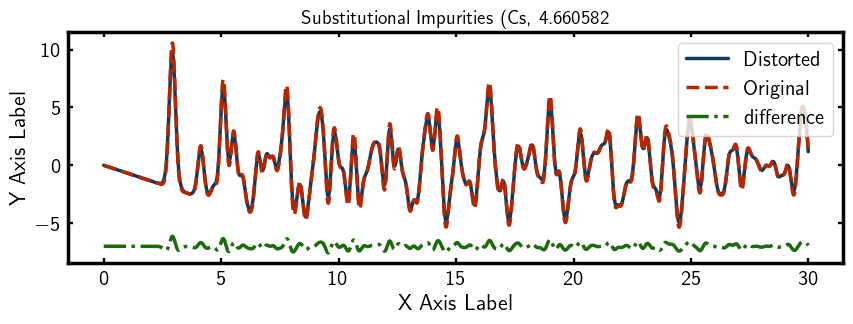

In [12]:
from distortion_learning.plot_utils import plot_processed_and_original
filename = 'pure_metal_vac/icsd_012174_dim5_vac_3p805487.gr'
filename = 'pure_metal_selfint/icsd_041511_dim5_selfint_6p482356.gr'
filename = 'pure_metal_int/icsd_043423_dim5_int_Sr_6p083174.gr'
filename = 'pure_metal_sub/icsd_043614_dim5_sub_Cs_4p660582.gr'
plot_processed_and_original(filename, normalization=None, offset=7, if_show=True, if_save=False, save_dir='../figs')

# Data Split

In [15]:
from distortion_learning.data_utils import get_pdf_filenames, split_data
data_directory = '../data/pdf'
pdf_filenames_list = get_pdf_filenames(data_directory)
split_data(pdf_filenames_list, train_ratio=.8, val_ratio=.1, if_save=True, save_directory="../distortion_learning")

In [16]:
from distortion_learning.data_utils import count_data_types
file_path = "../distortion_learning/data_split.json"
class_count = count_data_types(file_path, 'train')
print(class_count) # vac, sub, selfint, int

[2827, 2779, 2819, 2826]
